# Validate DTM with independent reference data sets

In [94]:
import os
import rasterio
import numpy as np
from eumap.raster import read_rasters
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score,mean_absolute_error
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
os.environ['USE_PYGEOS'] = '0'

## Part 1: independent reference high quality DTMs

The quality dataset is produced by Peter et al (2023), https://doi.org/10.5281/zenodo.8086806. The dataset has collected airborne DTMs from mainly from Europe, United States, and South America. It is used to validate in Bielski (2024) and Bielski (2023).



Reference:

Guth, P. L., Riazanoff, S., Corseaux, A., Grohmann, C., Trevisani, S., & López-Vázquez, C. (2023). DEMIX 1" Reference DEMs version 2.0 (2.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.8086806

Bielski, C.; López-Vázquez, C.; Grohmann, C.H.; Guth. P.L.; Hawker, L.; Gesch, D.; Trevisani, S.; Herrera-Cruz, V.; Riazanoff, S.; Corseaux, A.; Reuter, H.; Strobl, P., 2024. Novel approach for ranking DEMs: Copernicus DEM improves one arc second open global topography. IEEE Transactions on Geoscience & Remote Sensing.  vol. 62, pp. 1-22, 2024, Art no. 4503922, https://doi.org/10.1109/TGRS.2024.3368015

Bielski, C.; López-Vázquez, C.; Guth. P.L.; Grohmann, C.H. and the TMSG DEMIX Working Group, 2023. DEMIX Wine Contest Method Ranks ALOS AW3D30, COPDEM, and FABDEM as Top 1” Global DEMs: https://arxiv.org/pdf/2302.08425.pdf

In [2]:
# find the paths for the dataset. Please 
points_args=[i.path for i in os.scandir('reference_dtm/') if 'point' in i.name and 'tif' in i.name]

In [4]:
points_args

['reference_dtm/shenandoah_dtm_ref_1sec_point.tif',
 'reference_dtm/republican.river_dtm_ref_1sec_point.tif',
 'reference_dtm/madrid_dtm_ref_1sec_point.tif',
 'reference_dtm/sao.paolo_dtm_ref_1sec_point.tif',
 'reference_dtm/canyon.range_dtm_ref_1sec_point.tif',
 'reference_dtm/norway_dtm_ref_1sec_point.tif',
 'reference_dtm/chincoteague_dtm_ref_1sec_point.tif',
 'reference_dtm/almeria_dtm_ref_1sec_point.tif',
 'reference_dtm/trentino_dtm_ref_1sec_point.tif',
 'reference_dtm/ebro.delta_dtm_ref_1sec_point.tif',
 'reference_dtm/state.line_dtm_ref_1sec_point.tif',
 'reference_dtm/uruguay_dtm_ref_1sec_point.tif',
 'reference_dtm/pernambuco_dtm_ref_1sec_point.tif',
 'reference_dtm/new.orleans_dtm_ref_1sec_point.tif',
 'reference_dtm/pyrenees_dtm_ref_1sec_point.tif',
 'reference_dtm/redwoods_dtm_ref_1sec_point.tif',
 'reference_dtm/oxford_dtm_ref_1sec_point.tif',
 'reference_dtm/blackwater_dtm_ref_1sec_point.tif',
 'reference_dtm/canary.east_dtm_ref_1sec_point.tif',
 'reference_dtm/la.palma_

In [3]:
os.makedirs('tiles',exist_ok=True)

### Part 1.1 Global vs Local Models 

In [39]:
area='trentino'

#area='uruguay'
#ref_src  = rasterio.open(f'/mnt/slurm/jobs/edtm_modeling/reference_dtm/{area}_ref_1sec_point.tif')
ref_src  = rasterio.open(f'reference_dtm/{area}_dtm_ref_1sec_point.tif')
ref_pixel=ref_src.read(1)
ref_pixel[ref_pixel==255]=np.nan
ref_pixel[ref_pixel==-10000]=np.nan

outputs,_=read_rasters(raster_files=[#'/mnt/slurm/jobs/edtm_modeling/prediction/edtm_rf_uruguay.tif',
                               #f'/mnt/slurm/jobs/edtm_modeling/prediction/edtm_rf_{area}_global.tif',
                               f'tiles/gendtm_{area}.tif',
                                f'tiles/edtm_{area}.tif'])

In [40]:
tree_cover = rasterio.open(f'tiles/treecover_{area}.tif').read(1)

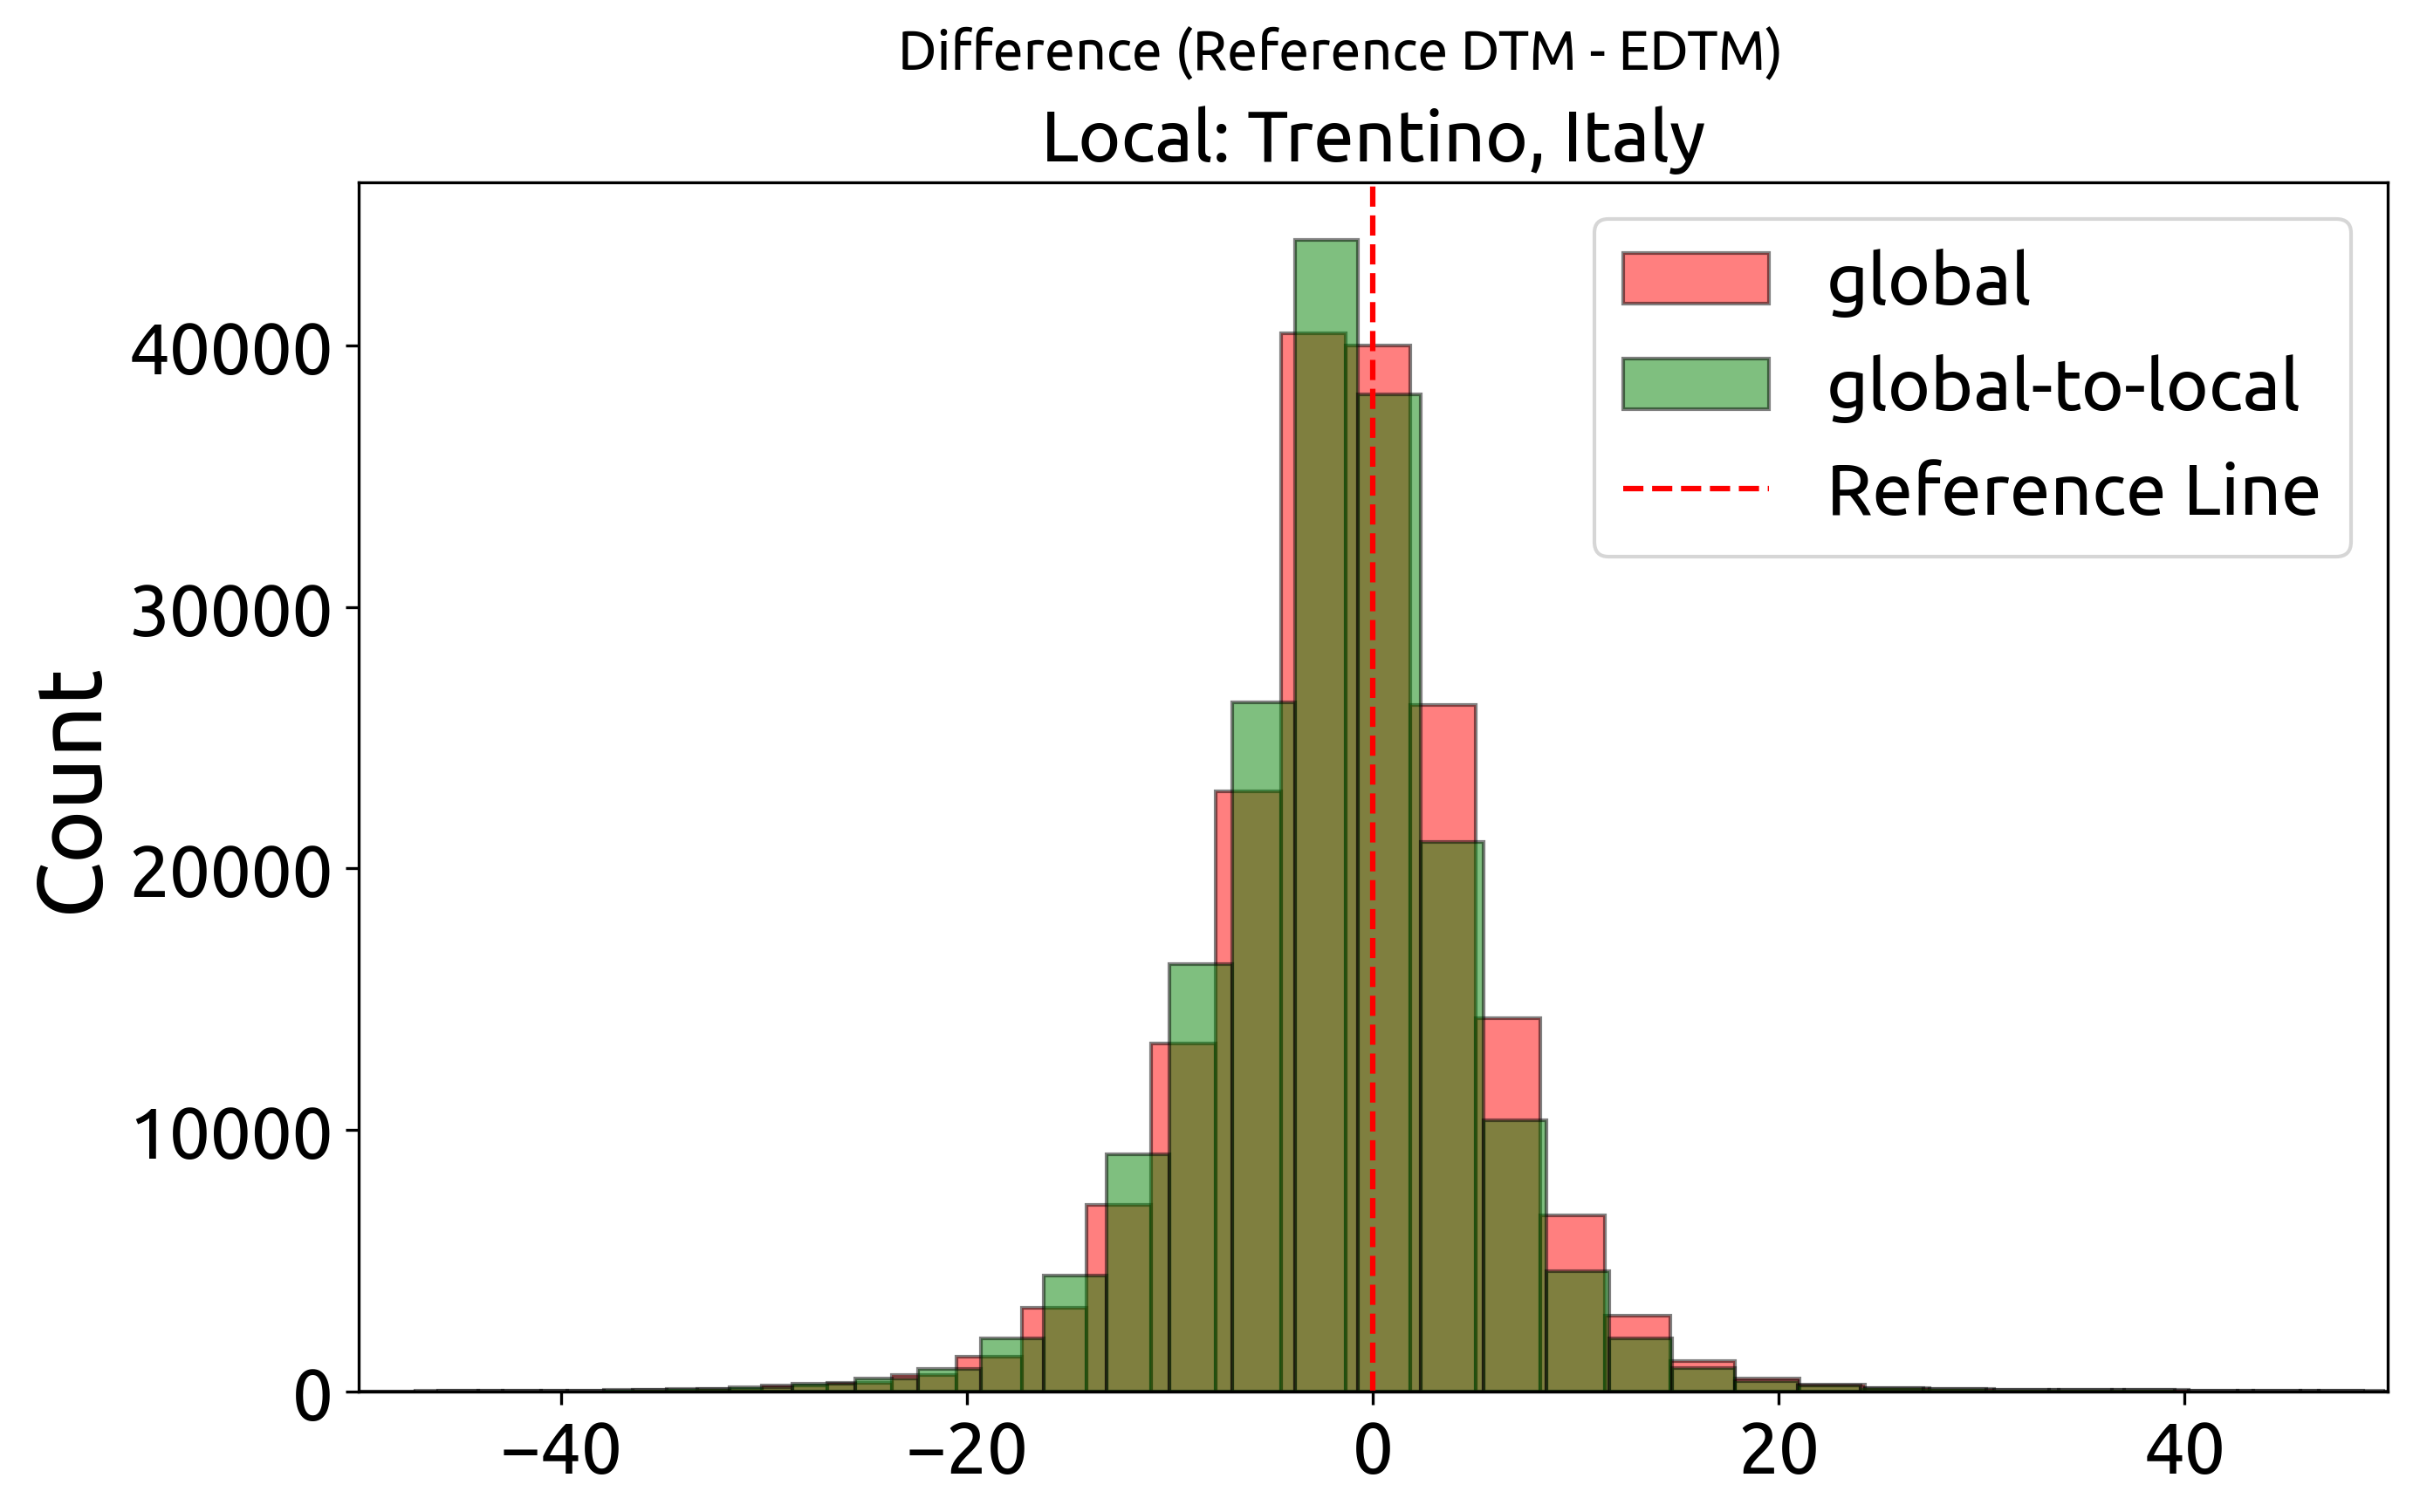

In [41]:
labels=['global','global-to-local']
colors=['red','green']
plt.figure(figsize=(10, 6), dpi=300)  # Set figure size and resolution (dpi)

for i,output in enumerate(range(outputs.shape[2])):
    y_predicted =  outputs[:,:,i]
    label = labels[i]
    mask = np.logical_and(~np.isnan(ref_pixel),~np.isnan(y_predicted))
    valid_ref= ref_pixel[mask]
    valid_y= y_predicted[mask]
    # Plotting the histograms
    label = labels[i]
    color = colors[i]
    valid_tree= tree_cover[mask]
    canopy_cover=valid_tree>=50
    
    rms = mean_squared_error(valid_ref[canopy_cover], valid_y[canopy_cover], squared=False)
    plt.hist(valid_ref-valid_y, bins=50, alpha=0.5, color=color, label=label, edgecolor='black')
    #plt.hist(g_edtm_diff, bins=50, alpha=0.9, color='green', label='global edtm', edgecolor='black')
    # Adding title and labels
plt.suptitle("Difference (Reference DTM - EDTM)",fontsize=15)
plt.title("Local: Trentino, Italy")
# Adding a vertical dashed line at x=0
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Reference Line')

#plt.xlabel("Difference (m)")
plt.ylabel("Count")
plt.xlim(-50,50)

# Adding legend
plt.legend()
# Saving the figure in high resolution
plt.savefig("histogram_difference_from_reference_dtm.png", dpi=300)  # Adjust dpi for desired resolutio

### Part 1.1 Accuracy assessment with dsms 

In [42]:
for tile_path in points_args:
    area=tile_path.split('/')[-1].split('_')[0]

    #if os.path.exists(f'/mnt/slurm/jobs/edtm_modeling/prediction/edtm_rf_{area}_local_merge.tif'):
    #    print(f'{area} prediction is finished')
    #else:
    ref_r = rasterio.open(tile_path)
    bbox = ' '.join([str(i) for i in ref_r.bounds])
    res=ref_r.transform[0]
    # get fabdem reference              
    
    gdalcmd = f'gdalwarp -overwrite -r bilinear -tr {res} {res} -te {bbox} \
    -co TILED=YES -co BIGTIFF=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co BLOCKXSIZE=2048 \
    -co BLOCKYSIZE=2048 -co NUM_THREADS=8 -co SPARSE_OK=TRUE'
    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.30:8333/global/edtm/dtm_elevation_aw3d30.dsm_m_30m_v01202022.tif \
    tiles/aw3d30_{area}.tif') 
    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.30:8333/global/edtm/GLO30_30m_v01272022.tif \
    tiles/glo30_{area}.tif') 
    
    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.30:8333/global/edtm/tree.cover_glad.umd_m_30m_s_20100101_20151231_go_epsg.4326_v1.0.tif \
    tiles/treecover_{area}.tif') 
    
    os.system(f'{gdalcmd} /mnt/slurm/jobs/edtm_modeling/wsf/wsf2019.vrt \
    tiles/wsf_{area}.tif') 
    

    os.system(f'{gdalcmd} fathom.vrt \
    tiles/tmp_fathom_{area}.tif') 

    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.40:8333/global/edtm/legendtm_rf_30m_m_s_20000101_20231231_go_epsg.4326_v20250130.tif \
    tiles/tmp_edtm_{area}.tif') 

    
    os.system(f'gdal_calc.py --overwrite -A tiles/tmp_edtm_{area}.tif \
    --outfile=tiles/edtm_{area}.tif --calc="A * 0.1" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')
    os.remove(f'tiles/tmp_edtm_{area}.tif')

    os.system(f'gdal_calc.py --overwrite -A tiles/tmp_fathom_{area}.tif \
    --outfile=tiles/fathom_{area}.tif --calc="A * 0.01" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')
    os.remove(f'tiles/tmp_fathom_{area}.tif')
    
    
    os.system(f'gdal_calc.py --overwrite -A tiles/fathom_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_fathom_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')

    os.system(f'gdal_calc.py --overwrite -A tiles/fathom_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_fathom_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')


Creating output file that is 1276P x 1002L.
Processing /vsicurl/http://192.168.49.30:8333/global/edtm/dtm_elevation_aw3d30.dsm_m_30m_v01202022.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1276P x 1002L.
Processing /vsicurl/http://192.168.49.30:8333/global/edtm/GLO30_30m_v01272022.tif [1/1] : 0Using internal nodata values (e.g. -32767) for image /vsicurl/http://192.168.49.30:8333/global/edtm/GLO30_30m_v01272022.tif.
Copying nodata values from source /vsicurl/http://192.168.49.30:8333/global/edtm/GLO30_30m_v01272022.tif to destination tiles/glo30_shenandoah.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1276P x 1002L.
Processing /vsicurl/http://192.168.49.30:8333/global/edtm/tree.cover_glad.umd_m_30m_s_20100101_20151231_go_epsg.4326_v1.0.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1276P x 1002L.
Processing /mnt/slurm/jobs/edtm_m

In [69]:
area='sao.paolo'
ref_src  = rasterio.open(f'reference_dtm/{area}_dtm_ref_1sec_point.tif')
ref_pixel=ref_src.read(1)
ref_pixel[ref_pixel==255]=np.nan
ref_pixel[ref_pixel==-10000]=np.nan

In [70]:
building_cover=rasterio.open(f'tiles/wsf_{area}.tif').read(1)

In [71]:
outputs,_=read_rasters(raster_files=[
                               f'tiles/edtm_{area}.tif',
                               f'tiles/glo30_{area}.tif',
                               f'tiles/aw3d30_{area}.tif'])

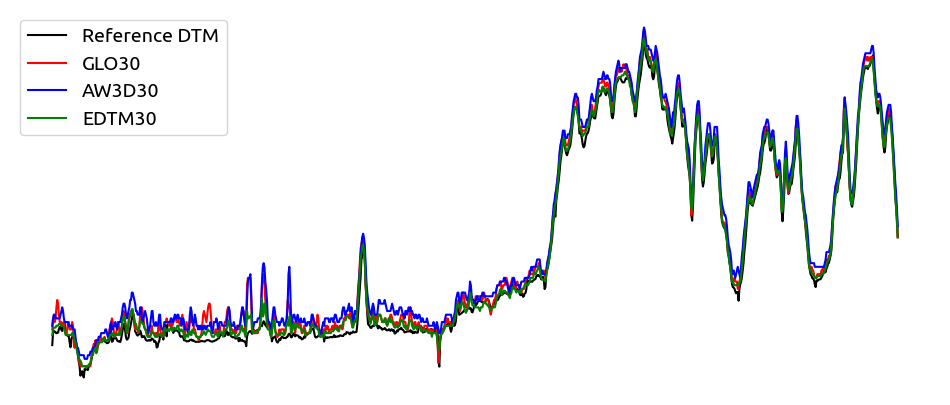

In [72]:
## SAO_PAOLO
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12,5))
ax = plt.gca()  # Get current axis
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['top'].set_visible(False)    # Hide the top spine
ax.spines['bottom'].set_visible(False)  # Hide the right spine
ax.spines['left'].set_visible(False)  # Hide the right spine
ax.set_xticks([])
ax.set_yticks([])
plt.rcParams['font.family'] = 'Ubuntu'

x = np.arange(410,len(ref_pixel[200,:-10]),1)
# first plot with X and Y data
plt.plot(x, ref_pixel[50,410:-10], color='black', label='Reference DTM')
# second plot with x1 and y1 data
plt.plot(x, outputs[50,410:-10,1], color='red', label='GLO30')
plt.plot(x, outputs[50,410:-10,2], color='blue', label='AW3D30')
plt.plot(x, outputs[50,410:-10,0], color='green', label='EDTM30')

plt.legend(fontsize="14", loc ="upper left")
plt.savefig("transect_sao.paolo.png", format='png', dpi=300)  # Adjust dpi for desired resolution

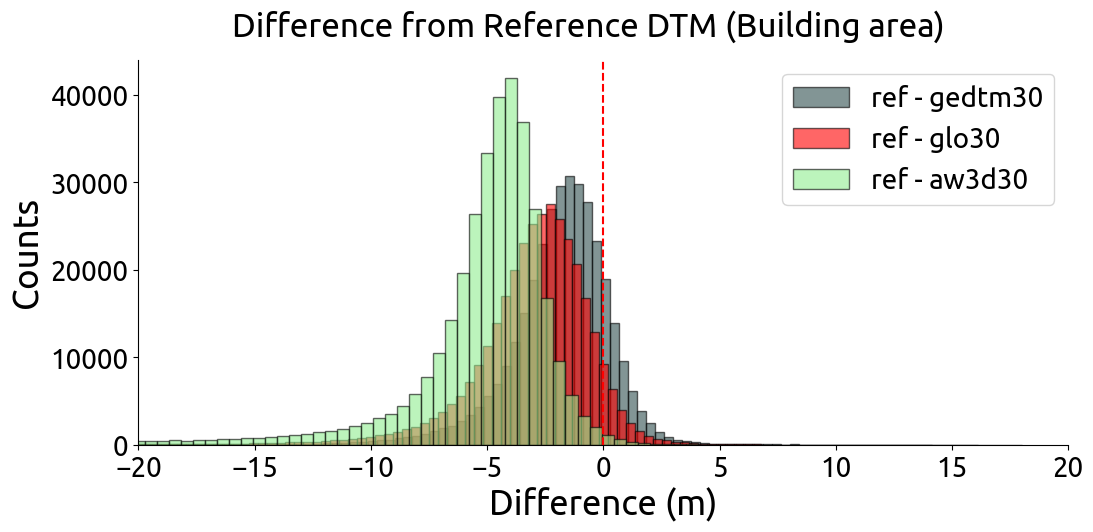

In [74]:
## building 
labels=['ref - gedtm30','ref - glo30','ref - aw3d30']
colors=['darkslategray','red','lightgreen']
# Set the font to Ubuntu
plt.rcParams['font.family'] = 'Ubuntu'
plt.figure(figsize=(12,5))
# Customizing the spines
ax = plt.gca()  # Get current axis
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['top'].set_visible(False)    # Hide the top spine
for i,output in enumerate(range(outputs.shape[2])):
    y_predicted =  outputs[:,:,i]
    label = labels[i]
    mask = np.logical_and(~np.isnan(ref_pixel),~np.isnan(y_predicted))
    valid_ref= ref_pixel[mask][1:-2]
    valid_y= y_predicted[mask][1:-2]
    valid_building= building_cover[mask][1:-2]
    building_mask=valid_building!=0
    plt.hist(valid_ref[building_mask]-valid_y[building_mask],bins=200,
             alpha=0.6,edgecolor='black',label=labels[i],
            color=colors[i])
plt.legend()
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Reference Line')
plt.xlabel("Difference (m)")
plt.ylabel("Counts")
plt.suptitle("Difference from Reference DTM (Building area)")
plt.xlim(-20,20)
# Saving the figure in high resolution
plt.savefig("histogram_building_cover.png", format='png', dpi=300)  # Adjust dpi for desired resolution

In [75]:
area='uruguay'
#area='uruguay'
#ref_src  = rasterio.open(f'/mnt/slurm/jobs/edtm_modeling/reference_dtm/{area}_ref_1sec_point.tif')
ref_src  = rasterio.open(f'reference_dtm/{area}_dtm_ref_1sec_point.tif')
ref_pixel=ref_src.read(1)
ref_pixel[ref_pixel==255]=np.nan
ref_pixel[ref_pixel==-10000]=np.nan

In [76]:
tree_cover=rasterio.open(f'tiles/treecover_{area}.tif').read(1)

In [77]:
outputs,_=read_rasters(raster_files=[
                               f'tiles/edtm_{area}.tif',
                               f'tiles/glo30_{area}.tif',
                               f'tiles/aw3d30_{area}.tif'])

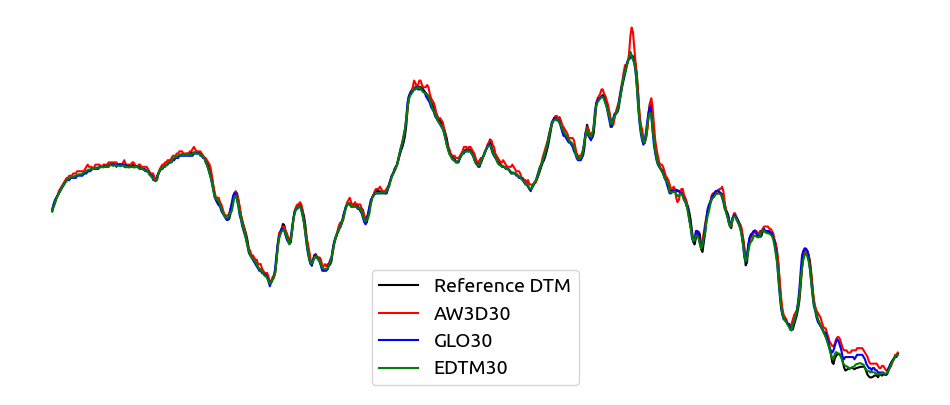

In [78]:
## Uruguay
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12,5))
ax = plt.gca()  # Get current axis
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['top'].set_visible(False)    # Hide the top spine
ax.spines['bottom'].set_visible(False)  # Hide the right spine
ax.spines['left'].set_visible(False)  # Hide the right spine
ax.set_xticks([])
ax.set_yticks([])
plt.rcParams['font.family'] = 'Ubuntu'

x = np.arange(10,len(ref_pixel[200,:-10]),1)
# first plot with X and Y data
plt.plot(x, ref_pixel[450,10:-10], color='black', label='Reference DTM')
# second plot with x1 and y1 data
#plt.plot(x, edtm, color='red', label='EDTM v1')
plt.plot(x, outputs[450,10:-10,2], color='red', label='AW3D30')
plt.plot(x, outputs[450,10:-10,1], color='blue', label='GLO30')
plt.plot(x, outputs[450,10:-10,0], color='green', label='EDTM30')

plt.legend(fontsize="14", loc ="lower center")
plt.savefig("transect_uruguay.png", format='png', dpi=300)  # Adjust dpi for desired resolution

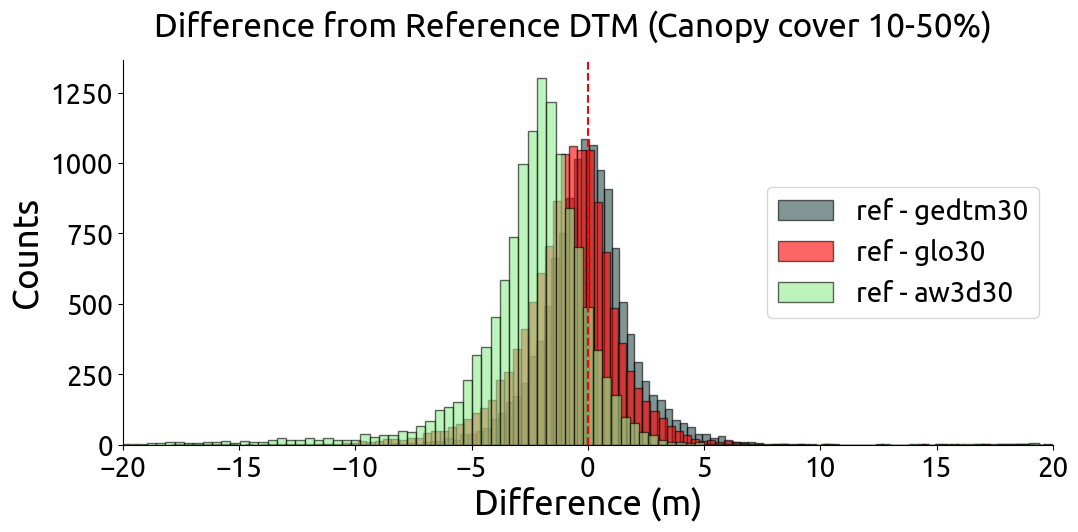

In [80]:
labels=['ref - gedtm30','ref - glo30','ref - aw3d30']
colors=['darkslategray','red','lightgreen']
# Set the font to Ubuntu
plt.rcParams['font.family'] = 'Ubuntu'
plt.figure(figsize=(12,5))
# Customizing the spines
ax = plt.gca()  # Get current axis
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['top'].set_visible(False)    # Hide the top spine
for i,output in enumerate(range(outputs.shape[2])):
    y_predicted =  outputs[:,:,i]
    label = labels[i]
    mask = np.logical_and(~np.isnan(ref_pixel),~np.isnan(y_predicted))
    valid_ref= ref_pixel[mask][1:-2]
    valid_y= y_predicted[mask][1:-2]
    valid_tree= tree_cover[mask][1:-2]
    canopy_cover=np.logical_and(valid_tree>=10,valid_tree<50)
    plt.hist(valid_ref[canopy_cover]-valid_y[canopy_cover],bins=200,
             alpha=0.6,edgecolor='black',label=labels[i],
            color=colors[i])
plt.legend(loc='right')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Reference Line')
plt.xlabel("Difference (m)")
plt.ylabel("Counts")
plt.suptitle("Difference from Reference DTM (Canopy cover 10-50%)")
plt.xlim(-20,20)
# Saving the figure in high resolution
plt.savefig("histogram_canopy_cover_10-50.png", format='png', dpi=300)  # Adjust dpi for desired resolution

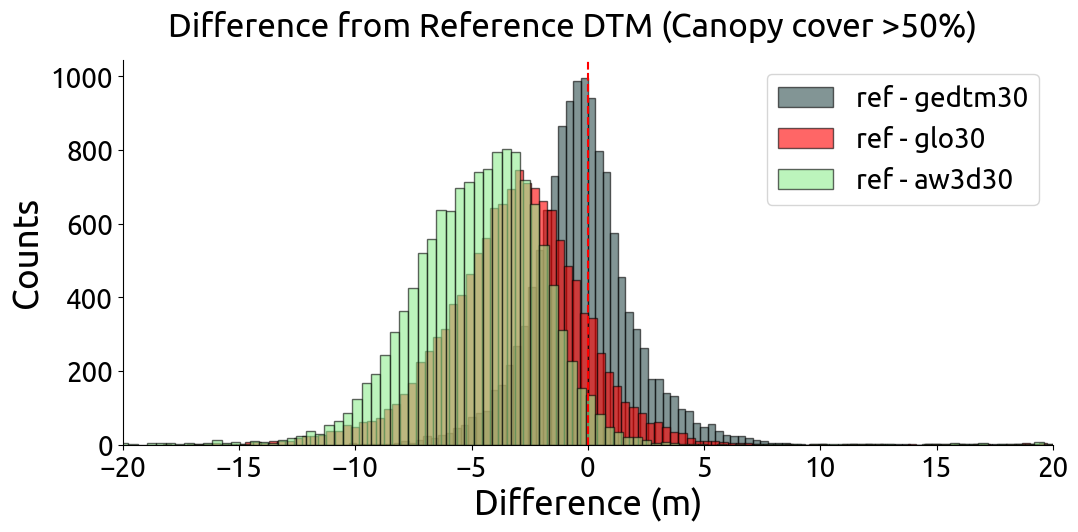

In [82]:
labels=['ref - gedtm30','ref - glo30','ref - aw3d30']
colors=['darkslategray','red','lightgreen']
# Set the font to Ubuntu
plt.rcParams['font.family'] = 'Ubuntu'
plt.figure(figsize=(12,5))
# Customizing the spines
ax = plt.gca()  # Get current axis
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['top'].set_visible(False)    # Hide the top spine
for i,output in enumerate(range(outputs.shape[2])):
    y_predicted =  outputs[:,:,i]
    mask = np.logical_and(~np.isnan(ref_pixel),~np.isnan(y_predicted))
    valid_ref= ref_pixel[mask][1:-2]
    valid_y= y_predicted[mask][1:-2]
    valid_tree= tree_cover[mask][1:-2]
    canopy_cover=valid_tree>=50
    plt.hist(valid_ref[canopy_cover]-valid_y[canopy_cover],bins=200,
             alpha=0.6,edgecolor='black',label=labels[i],
            color=colors[i])
plt.legend()
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Reference Line')
plt.xlabel("Difference (m)")
plt.ylabel("Counts")
plt.suptitle("Difference from Reference DTM (Canopy cover >50%)")
#lt.title("Location: Departamento de Artigas, Uruguay", fontsize=10)
plt.xlim(-20,20)
# Saving the figure in high resolution
plt.savefig("histogram_canopy_cover_50.png", format='png', dpi=300)  # Adjust dpi for desired resolution

### Part 1.1 Accuracy assessment by sites 

In [83]:
# evaluate for all sites
# pick 3 sites that was selected for visual inspection
areas = ['trentino','chincoteague','norway']
df_all=[]
for area in areas:
    ref_src  = rasterio.open(f'reference_dtm/{area}_dtm_ref_1sec_point.tif')
    ref_pixel=ref_src.read(1)
    ref_pixel[ref_pixel==255]=np.nan
    ref_pixel[ref_pixel==-10000]=np.nan
    outputs,_=read_rasters(raster_files=[
                               f'tiles/merit_{area}.tif',
                               f'tiles/fabdem_{area}.tif',
                               f'tiles/fathom_{area}.tif',
                               f'tiles/edtm_{area}.tif'],dtype=np.float32)
    labels=['MERIT DEM','FABDEM','FATHOM','GEDTM30']
    aggr=np.mean(outputs,axis=2) # aggregate to find the common value pixels for comparison 
    mask = np.logical_and(np.isfinite(ref_pixel),np.isfinite(aggr))
    # rescale GEDTM to meter unit
    df=[]
    for i in range(outputs.shape[2]):
        if i>2:
            y_predicted =  outputs[:,:,i]*0.1
        elif i==2:
            y_predicted =  outputs[:,:,i]*0.01
        else:
            y_predicted =  outputs[:,:,i]
        name=labels[i]

        rms = mean_squared_error(ref_pixel[mask], y_predicted[mask], squared=False)
        mae = mean_absolute_error(ref_pixel[mask], y_predicted[mask])
        mbe = np.mean(ref_pixel[mask]- y_predicted[mask])
        d = {}
        d['Location']=area.replace('trentino','Trentino, Italy').replace('chincoteague','Chincoteague, the USA').replace('norway','Vestfold, Norway')
        d['Dataset']=name
        d['Valid pixels']=len(y_predicted[mask])
        d['RMSE']=round(rms,2)
        d['MAE']=round(mae,2)
        d['MBE']=round(mbe,2)
        df.append(d)
        area_df=pd.DataFrame(df)
    df_all.append(area_df)


In [95]:
# Create a lidar of difference from reference for visual inspection
for tile_path in points_args:
    area=tile_path.split('/')[-1].split('_')[0]
    ref_r = rasterio.open(tile_path)
    bbox = ' '.join([str(i) for i in ref_r.bounds])
    res=ref_r.transform[0]
    # get fabdem reference              
    
    gdalcmd = f'gdalwarp -overwrite -r bilinear -tr {res} {res} -te {bbox} \
    -co TILED=YES -co BIGTIFF=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co BLOCKXSIZE=2048 \
    -co BLOCKYSIZE=2048 -co NUM_THREADS=8 -co SPARSE_OK=TRUE'
    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.30:8333/global/edtm/FABDEM_v20230126_resize.tif \
    tiles/fabdem_{area}.tif') 
    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.30:8333/global/edtm/merit_30m_v01262022.tif \
    tiles/merit_{area}.tif') 

    
    os.system(f'{gdalcmd} fathom.vrt \
    tiles/tmp_fathom_{area}.tif') 

    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.40:8333/global/edtm/legendtm_rf_30m_m_s_20000101_20231231_go_epsg.4326_v20250130.tif \
    tiles/tmp_edtm_{area}.tif') 
    
    os.system(f'gdal_calc.py --overwrite -A tiles/tmp_edtm_{area}.tif \
    --outfile=tiles/edtm_{area}.tif --calc="A * 0.1" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')
    os.remove(f'tiles/tmp_edtm_{area}.tif')

    os.system(f'gdal_calc.py --overwrite -A tiles/tmp_fathom_{area}.tif \
    --outfile=tiles/fathom_{area}.tif --calc="A * 0.01" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')
    os.remove(f'tiles/tmp_fathom_{area}.tif')

    os.system(f'gdal_calc.py --overwrite -A tiles/gendtm_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_gendtm_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')
    
    
    os.system(f'gdal_calc.py --overwrite -A tiles/fathom_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_fathom_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')

    os.system(f'gdal_calc.py --overwrite -A tiles/edtm_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_edtm_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')

    
    os.system(f'gdal_calc.py --overwrite -A tiles/fabdem_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_fabdem_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')

    os.system(f'gdal_calc.py --overwrite -A tiles/merit_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_merit_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')


Creating output file that is 1276P x 1002L.
Processing /vsicurl/http://192.168.49.30:8333/global/edtm/FABDEM_v20230126_resize.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image /vsicurl/http://192.168.49.30:8333/global/edtm/FABDEM_v20230126_resize.tif.
Copying nodata values from source /vsicurl/http://192.168.49.30:8333/global/edtm/FABDEM_v20230126_resize.tif to destination tiles/fabdem_shenandoah.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1276P x 1002L.
Processing /vsicurl/http://192.168.49.30:8333/global/edtm/merit_30m_v01262022.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image /vsicurl/http://192.168.49.30:8333/global/edtm/merit_30m_v01262022.tif.
Copying nodata values from source /vsicurl/http://192.168.49.30:8333/global/edtm/merit_30m_v01262022.tif to destination tiles/merit_shenandoah.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1276P x 1002L.
Processin

In [96]:
# evaluate for all sites
# pick 3 sites that was selected for visual inspection
areas = ['trentino','chincoteague','norway']
df_all=[]
for area in areas:
    ref_src  = rasterio.open(f'reference_dtm/{area}_dtm_ref_1sec_point.tif')
    ref_pixel=ref_src.read(1)
    ref_pixel[ref_pixel==255]=np.nan
    ref_pixel[ref_pixel==-10000]=np.nan
    outputs,_=read_rasters(raster_files=[
                               f'tiles/merit_{area}.tif',
                               f'tiles/fabdem_{area}.tif',
                               f'tiles/fathom_{area}.tif',
                               f'tiles/edtm_{area}.tif'],dtype=np.float32)
    labels=['MERIT DEM','FABDEM','FATHOM','GEDTM30']
    aggr=np.mean(outputs,axis=2) # aggregate to find the common value pixels for comparison 
    mask = np.logical_and(np.isfinite(ref_pixel),np.isfinite(aggr))
    # rescale GEDTM to meter unit
    df=[]
    for i in range(outputs.shape[2]):
        y_predicted =  outputs[:,:,i]
        name=labels[i]

        rms = mean_squared_error(ref_pixel[mask], y_predicted[mask], squared=False)
        mae = mean_absolute_error(ref_pixel[mask], y_predicted[mask])
        mbe = np.mean(ref_pixel[mask]- y_predicted[mask])
        d = {}
        d['Location']=area.replace('trentino','Trentino, Italy').replace('chincoteague','Chincoteague, the USA').replace('norway','Vestfold, Norway')
        d['Dataset']=name
        d['Valid pixels']=len(y_predicted[mask])
        d['RMSE']=round(rms,2)
        d['MAE']=round(mae,2)
        d['MBE']=round(mbe,2)
        df.append(d)
        area_df=pd.DataFrame(df)
    df_all.append(area_df)


In [97]:
com_df=pd.concat(df_all)
com_df

,Location,Dataset,Valid pixels,RMSE,MAE,MBE
0,"Trentino, Italy",MERIT DEM,182618,13.20,9.98,-5.45
1,"Trentino, Italy",FABDEM,182618,8.93,6.29,-3.32
2,"Trentino, Italy",FATHOM,182618,5.45,3.82,-1.29
3,"Trentino, Italy",GEDTM30,182618,7.09,5.08,-1.83
0,"Chincoteague, the USA",MERIT DEM,880611,2.08,1.63,-1.35
1,"Chincoteague, the USA",FABDEM,880611,3.33,1.77,-1.43
2,"Chincoteague, the USA",FATHOM,880611,0.85,0.57,-0.24
3,"Chincoteague, the USA",GEDTM30,880611,2.14,1.40,-0.72
0,"Vestfold, Norway",MERIT DEM,2563774,5.21,3.83,-1.49
1,"Vestfold, Norway",FABDEM,2563774,4.45,3.11,0.82


In [98]:
# pick 3 sites that was selected for visual inspection
areas = [i.split('/')[-1].split('_')[0] for i in points_args]
df_all=[]
for area in areas:
    ref_src  = rasterio.open(f'reference_dtm/{area}_dtm_ref_1sec_point.tif')
    ref_pixel=ref_src.read(1)
    ref_pixel[ref_pixel==255]=np.nan
    ref_pixel[ref_pixel==-10000]=np.nan
    outputs,_=read_rasters(raster_files=[
                               f'tiles/merit_{area}.tif',
                               f'tiles/fabdem_{area}.tif',
                               f'tiles/fathom_{area}.tif',
                               f'tiles/edtm_{area}.tif'],dtype=np.float32)
    labels=['MERIT DEM','FABDEM','EDTM','FATHOM']
    aggr=np.mean(outputs,axis=2) # aggregate to find the common value pixels for comparison 
    mask = np.logical_and(np.isfinite(ref_pixel),np.isfinite(aggr))
    # rescale GEDTM to meter unit
    df=[]
    for i in range(outputs.shape[2]):
        y_predicted =  outputs[:,:,i]
        name=labels[i]

        rms = mean_squared_error(ref_pixel[mask], y_predicted[mask], squared=False)
        mae = mean_absolute_error(ref_pixel[mask], y_predicted[mask])
        mbe = np.mean(ref_pixel[mask]- y_predicted[mask])
        d = {}
        d['Location']=area.replace('trentino','Trentino, Italy').replace('chincoteague','Chincoteague, the USA').replace('norway','Vestfold, Norway')
        d['Dataset']=name
        d['Valid pixels']=len(y_predicted[mask])
        d['RMSE']=round(rms,2)
        d['MAE']=round(mae,2)
        d['MBE']=round(mbe,2)
        df.append(d)
        area_df=pd.DataFrame(df)
    df_all.append(area_df)


In [99]:
com_df=pd.concat(df_all)
com_df

,Location,Dataset,Valid pixels,RMSE,MAE,MBE
0,shenandoah,MERIT DEM,940321,7.01,5.24,-3.17
1,shenandoah,FABDEM,940321,5.29,3.86,0.06
2,shenandoah,EDTM,940321,3.19,2.19,-0.82
3,shenandoah,FATHOM,940321,4.46,3.36,0.60
0,republican.river,MERIT DEM,3402316,2.40,1.93,-1.72
...,...,...,...,...,...,...
3,la.palma,FATHOM,881953,15.36,7.03,-1.94
0,charleston,MERIT DEM,1115800,2.30,1.95,-1.61
1,charleston,FABDEM,1115800,2.77,1.73,-1.24
2,charleston,EDTM,1115800,0.94,0.74,-0.53


<Axes: xlabel='Location', ylabel='RMSE'>

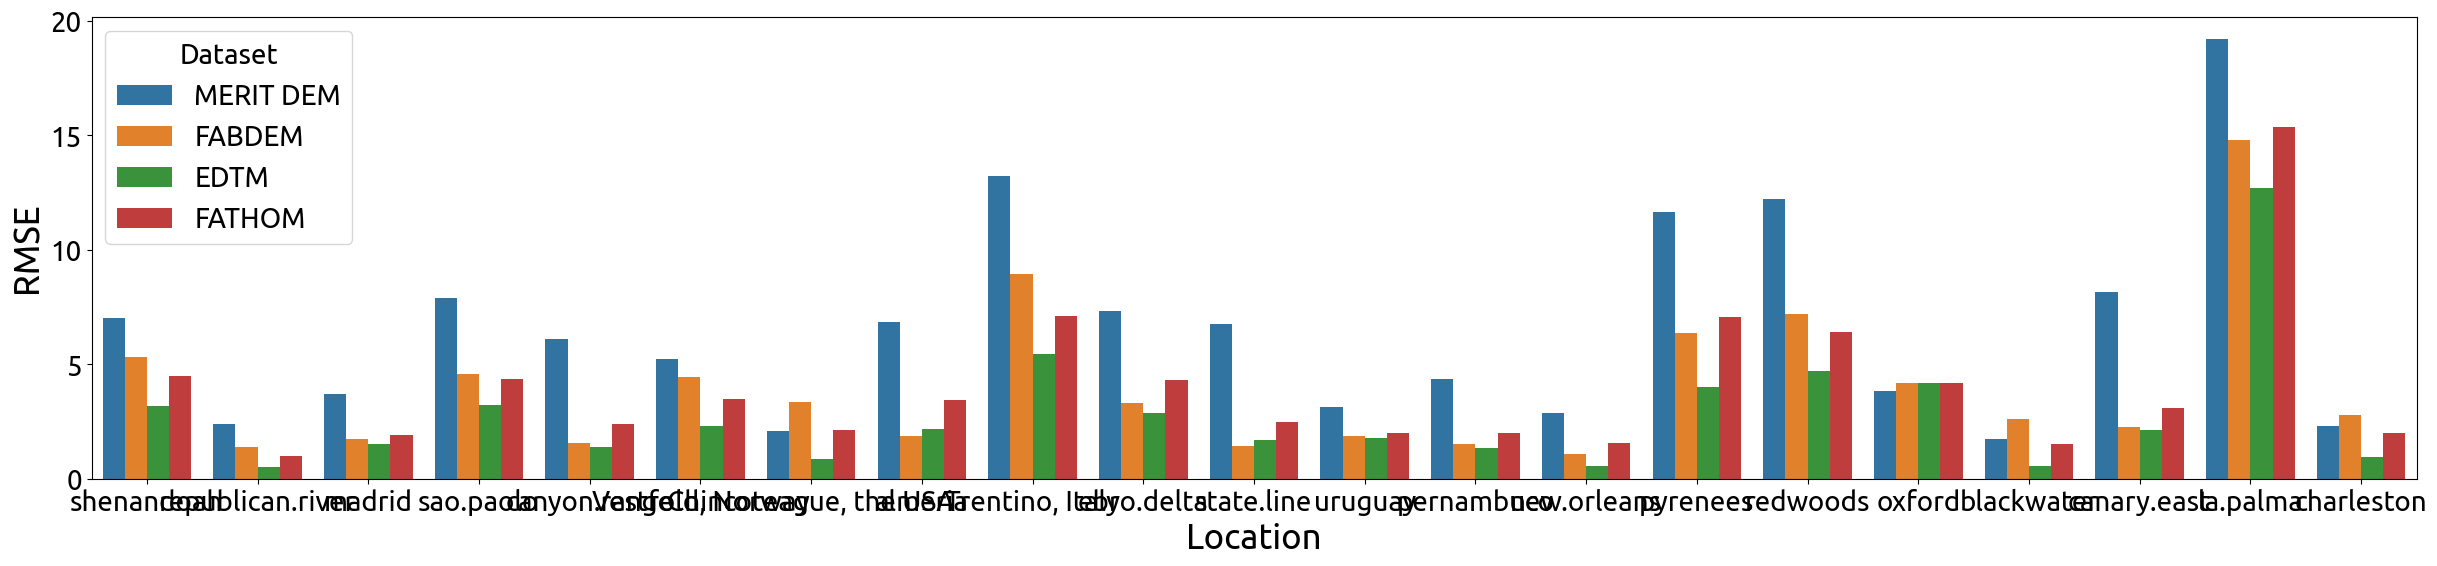

In [100]:
com_df=pd.concat(df_all)

plt.figure(figsize=(30, 6))
sns.barplot(data=com_df, x="Location", hue="Dataset", y="RMSE",)
#plt.savefig('barplot_comparison.png')

## Part 1.2 Accuracy assessment by land cover

In [101]:
for tile_path in points_args:
    area=tile_path.split('/')[-1].split('_')[0]

    #if os.path.exists(f'/mnt/slurm/jobs/edtm_modeling/prediction/edtm_rf_{area}_local_merge.tif'):
    #    print(f'{area} prediction is finished')
    #else:
    ref_r = rasterio.open(tile_path)
    bbox = ' '.join([str(i) for i in ref_r.bounds])
    res=ref_r.transform[0]
    # get fabdem reference              

    gdalcmd = f'gdalwarp -overwrite -r mode -tr {res} {res} -te {bbox} \
    -co TILED=YES -co BIGTIFF=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co BLOCKXSIZE=2048 \
    -co BLOCKYSIZE=2048 -co NUM_THREADS=8 -co SPARSE_OK=TRUE'
    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif \
                                    tiles/glad.glcluc.change_{area}.tif')
              

Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 1276P x 1002L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 2963P x 1335L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 3636P x 1547L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 1441P x 1799L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 2111P x 1320L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 2983P x 1074L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 1645P x 980L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 3628P x 1834L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 480P x 397L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 3769P x 2523L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 2029P x 1974L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 666P x 662L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 721P x 719L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 775P x 991L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 1227P x 628L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 1247P x 977L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 1582P x 819L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 1667P x 1313L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 4267P x 5047L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 1270P x 1552L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


Creating output file that is 1556P x 1636L.
Processing /vsicurl/http://192.168.49.45:8333/global/lc/lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [102]:
## aggregate lulc classes
cropland=244
buildup=250
forest=range(25,49)
sparse_grass=range(2,19)
dense_grass=range(19,25)
desert=range(0,2)

In [108]:
labels=['MERIT DEM','FABDEM','FathomDEM','EDTM']
df=[]
num_all_pixels=0
area_args=[i.split('/')[-1].split('_')[0] for i in points_args]
for area in area_args:
    lulc=rasterio.open(f'tiles/glad.glcluc.change_{area}.tif').read(1)
    p_cropland = (lulc==cropland).astype('uint8')
    p_buildup = (lulc==buildup).astype('uint8')
    p_forest=np.zeros([lulc.shape[0],lulc.shape[1]])
    for i in forest:
        p_forest += (lulc==i).astype('uint8')    
    p_desert=np.zeros([lulc.shape[0],lulc.shape[1]])
    for i in desert:
        p_desert += (lulc==i).astype('uint8')
    p_dense_grass=np.zeros([lulc.shape[0],lulc.shape[1]])
    for i in dense_grass:
        p_dense_grass += (lulc==i).astype('uint8')
    p_sparse_grass=np.zeros([lulc.shape[0],lulc.shape[1]])
    for i in sparse_grass:
        p_sparse_grass += (lulc==i).astype('uint8')

    ref_src  = rasterio.open(f'reference_dtm/{area}_dtm_ref_1sec_point.tif')
    ref_pixel=ref_src.read(1)
    ref_pixel[ref_pixel==255]=np.nan
    ref_pixel[ref_pixel==-10000]=np.nan

    for info in [['Cropland, stable',p_cropland],['Built-up, stable built-up',p_buildup],
                 ['Terra Firma, stable tree cover',p_forest],['Terra Firma, true desert',p_desert],
                 ['Terra Firma, semi-arid',p_sparse_grass],['Terra Firma, dense short vegetation',p_dense_grass]]:
        land_str=info[0]
        landcover=info[1]
        inputs,_=read_rasters(raster_files=[
                               f'tiles/merit_{area}.tif',
                               f'tiles/fabdem_{area}.tif',
                               f'tiles/fathom_{area}.tif',
                               f'tiles/edtm_{area}.tif'],dtype=np.float32,n_jobs=5)
        for i,output in enumerate(range(inputs.shape[2])):
            y_predicted =  inputs[:,:,i]

            name=labels[i]
            landcover_mask=landcover==1
            mask = np.logical_and(np.logical_and(~np.isnan(ref_pixel),~np.isnan(y_predicted)),landcover_mask)
            d = {}
            d['residual']=ref_pixel[mask]-y_predicted[mask]
            d['label']=name
            d['Land cover (c)']=land_str
            d['location']=area
            d['num_pixels']=len(ref_pixel[mask])
            df.append(d)
    num_all_pixels+= len(ref_pixel[~np.isnan(ref_pixel)])
area_df=pd.DataFrame(df)


In [109]:
pixel_nums_df=area_df[['label','num_pixels','Land cover (c)']][area_df['label']=='FABDEM'].groupby(['Land cover (c)']).sum()
pixel_nums_df['Land cover (%)']=round(pixel_nums_df['num_pixels']/num_all_pixels*100,1)
pixel_nums_df.reset_index(inplace=True)

In [110]:
df=[]
for land_str in ['Cropland, stable','Built-up, stable built-up','Terra Firma, true desert','Terra Firma, stable tree cover','Terra Firma, semi-arid', 'Terra Firma, dense short vegetation']:
    for label in labels:
        metrics_table={}
        pixels=np.concatenate([i for i in area_df[np.logical_and(area_df['Land cover (c)']==land_str,area_df['label']==label)].residual])
        metrics_table['Dataset']=label
        metrics_table['Land cover (c)']=land_str
        metrics_table['RMSE']=np.round(np.sqrt((pixels**2).mean()),2)
        metrics_table['MAE']=np.round(abs(pixels).mean(),2)
        metrics_table['ME']=np.round(pixels.mean(),2)

        df.append(metrics_table)

In [111]:
tmp=pd.DataFrame(df)
land_cover_acc  = pd.merge(left=tmp,right=pixel_nums_df[['Land cover (c)','Land cover (%)']],on='Land cover (c)')

In [112]:
land_cover_acc[['Dataset','Land cover (c)','Land cover (%)','RMSE','MAE','ME']]

,Dataset,Land cover (c),Land cover (%),RMSE,MAE,ME
0,MERIT DEM,"Cropland, stable",11.3,2.31,1.79,-0.91
1,FABDEM,"Cropland, stable",11.3,1.65,1.03,0.34
2,FathomDEM,"Cropland, stable",11.3,1.45,0.82,0.39
3,EDTM,"Cropland, stable",11.3,1.56,0.95,0.38
4,MERIT DEM,"Built-up, stable built-up",12.5,4.76,3.19,-1.79
5,FABDEM,"Built-up, stable built-up",12.5,2.74,1.67,0.32
6,FathomDEM,"Built-up, stable built-up",12.5,1.95,1.23,0.50
7,EDTM,"Built-up, stable built-up",12.5,2.75,1.75,0.04
8,MERIT DEM,"Terra Firma, true desert",5.3,6.16,4.44,-2.82
9,FABDEM,"Terra Firma, true desert",5.3,1.81,0.71,0.02


## Part 2: independent GNSS terrain height

The quality dataset is published by NGL GNSS (http://geodesy.unr.edu/), https://doi.org/10.5281/zenodo.8086806. The dataset has collected airborne DTMs from mainly from Europe, United States, and South America. It is used to validate in Bielski (2024) and Bielski (2023).



Reference:


In [127]:
gdf=gpd.read_file('validation_gnss.geojson')

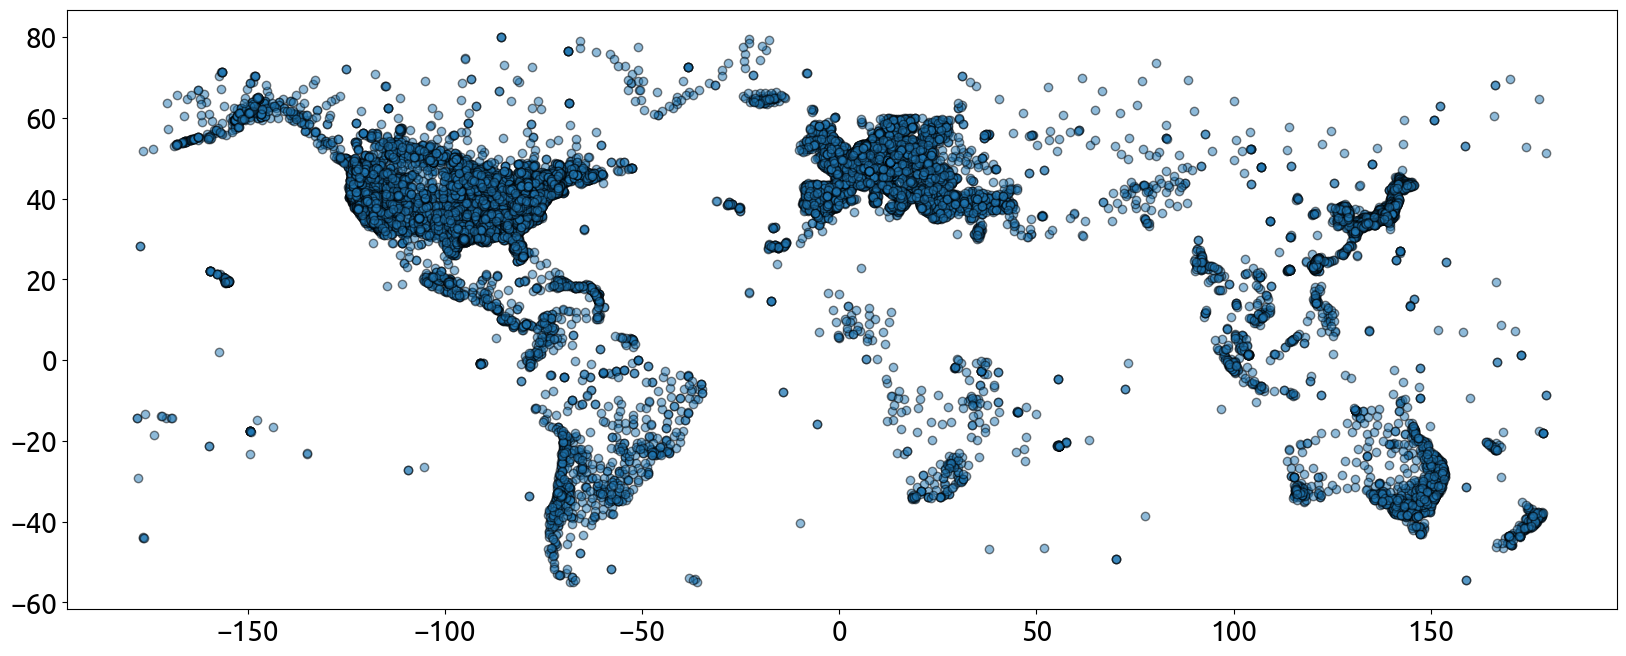

In [128]:
# zshows the distribution of the data
ax=gdf.to_crs("EPSG:4326").plot(figsize=(20, 10), alpha=0.5, edgecolor="k")

In [129]:
# correct gnss WGS
# H = h - N  ->  orthometric height = ellipsoid height - geoid height 
gdf['dtm_y']=gdf['height']-gdf['geoid_eigen_gfz']

In [130]:
gdf.dropna(inplace=True)

In [131]:
gdf['EDTM'] = gdf['LENGEN-DTM'] * 0.1

In [132]:
gdf['FathomDEM'] = gdf['FATHOM'] * 0.01

In [133]:
def calc_metrics(df,column):
    std = round(np.std(df['dtm_y']-df[column]),2)
    rms = round(np.sqrt(sum((df['dtm_y']-df[column])**2)/len(df)),2)
    m = round(np.mean(df['dtm_y']-df[column]),2)
    return std,rms,m

In [134]:
metrics=pd.DataFrame([])

In [135]:
metrics['metrics']=['std','rms','m']
metrics['EDTM']=calc_metrics(gdf,'EDTM')
metrics['MERIT DEM']=calc_metrics(gdf,'MERIT DEM')
metrics['FABDEM']=calc_metrics(gdf,'FABDEM')
metrics['FathomDEM']=calc_metrics(gdf,'FathomDEM')

In [136]:
metrics

,metrics,EDTM,MERIT DEM,FABDEM,FathomDEM
0,std,7.77,9.59,8.10,8.15
1,rms,10.69,12.57,11.52,11.59
2,m,7.34,8.14,8.19,8.24


In [137]:
gdf['residual_edtm']=gdf['dtm_y']-gdf['EDTM']
gdf['residual_fabdem']=gdf['dtm_y']-gdf['FABDEM']
gdf['residual_merit']=gdf['dtm_y']-gdf['MERIT DEM']
gdf['residual_fathomdem']=gdf['dtm_y']-gdf['FathomDEM']

In [138]:
std_edtm, rms_edtm, m_edtm = calc_metrics(gdf,'EDTM')
std_merit, rms_merit, m_merit = calc_metrics(gdf,'MERIT DEM')
std_fab, rms_fab, m_fab = calc_metrics(gdf,'FABDEM')
std_fat, rms_fat, m_fat = calc_metrics(gdf,'FathomDEM')

In [139]:
dfs_gnss=[]
for column in [[f'EDTM (mean: {m_edtm}, std:{std_edtm}, rmse:{rms_edtm})', 'residual_edtm'],
                [f'MERIT DEM (mean: {m_merit}, std:{std_merit}, rmse:{rms_merit})','residual_merit'],
                [f'FABDEM (mean: {m_fab}, std:{std_fab}, rmse:{rms_fab})','residual_fabdem'],
              [f'FathomDEM (mean: {m_fat}, std:{std_fat}, rmse:{rms_fat})','residual_fathomdem']]:
    df_gnss= pd.DataFrame([])
    df_gnss['difference']=gdf[column[1]]
    df_gnss['label']=column[0]
    dfs_gnss.append(df_gnss)

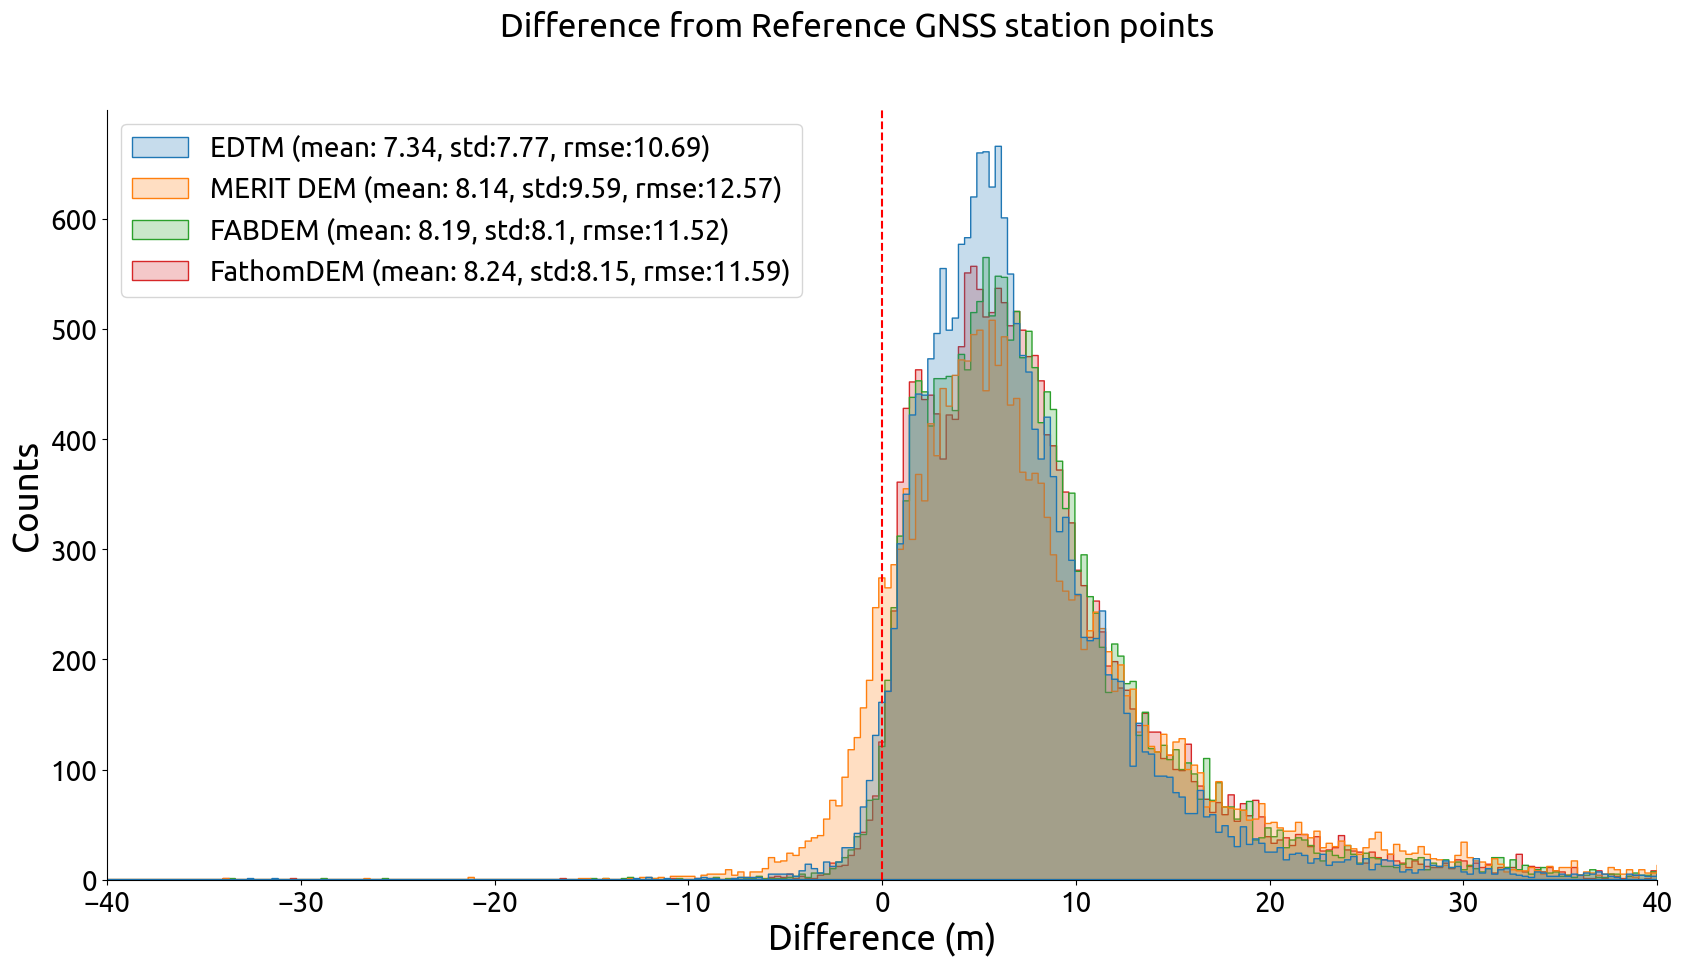

In [140]:
import seaborn as sns
fontsize = 20
plt.rcParams['font.family'] = 'Ubuntu'
plt.figure(figsize=(20,10))
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize+5)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize

ax = plt.gca()  # Get current axis
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['top'].set_visible(False)    # Hide the top spine

g=sns.histplot(pd.concat(dfs_gnss), x="difference", hue="label", element="step")
g.legend_.set_title(None)

sns.move_legend(ax, "upper left")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Reference Line')
plt.xlabel("Difference (m)")
plt.ylabel("Counts")
plt.suptitle("Difference from Reference GNSS station points")
plt.xlim(-40,40)
plt.savefig('diff_gnss.png')

# Part 3: Visual inspection on QGIS

In [ ]:
# Create a lidar of difference from reference for visual inspection
for tile_path in points_args:
    area=tile_path.split('/')[-1].split('_')[0]
    ref_r = rasterio.open(tile_path)
    bbox = ' '.join([str(i) for i in ref_r.bounds])
    res=ref_r.transform[0]
    # get fabdem reference              
    
    gdalcmd = f'gdalwarp -overwrite -r bilinear -tr {res} {res} -te {bbox} \
    -co TILED=YES -co BIGTIFF=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co BLOCKXSIZE=2048 \
    -co BLOCKYSIZE=2048 -co NUM_THREADS=8 -co SPARSE_OK=TRUE'
    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.30:8333/global/edtm/FABDEM_v20230126_resize.tif \
    tiles/fabdem_{area}.tif') 
    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.30:8333/global/edtm/merit_30m_v01262022.tif \
    tiles/merit_{area}.tif') 

    
    os.system(f'{gdalcmd} fathom.vrt \
    tiles/tmp_fathom_{area}.tif') 

    os.system(f'{gdalcmd} /vsicurl/http://192.168.49.40:8333/global/edtm/legendtm_rf_30m_m_s_20000101_20231231_go_epsg.4326_v20250130.tif \
    tiles/tmp_edtm_{area}.tif') 
    
    os.system(f'gdal_calc.py --overwrite -A tiles/tmp_edtm_{area}.tif \
    --outfile=tiles/edtm_{area}.tif --calc="A * 0.1" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')
    os.remove(f'tiles/tmp_edtm_{area}.tif')

    os.system(f'gdal_calc.py --overwrite -A tiles/tmp_fathom_{area}.tif \
    --outfile=tiles/fathom_{area}.tif --calc="A * 0.01" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')
    os.remove(f'tiles/tmp_fathom_{area}.tif')

    os.system(f'gdal_calc.py --overwrite -A tiles/gendtm_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_gendtm_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')
    
    
    os.system(f'gdal_calc.py --overwrite -A tiles/fathom_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_fathom_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')

    os.system(f'gdal_calc.py --overwrite -A tiles/edtm_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_edtm_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')

    
    os.system(f'gdal_calc.py --overwrite -A tiles/fabdem_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_fabdem_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')

    os.system(f'gdal_calc.py --overwrite -A tiles/merit_{area}.tif -B reference_dtm/{area}_dtm_ref_1sec_point.tif \
    --outfile=tiles/ref_merit_{area}.tif --calc="B-A" \
    --type=Float32 --co="COMPRESS=DEFLATE" --co="BLOCKXSIZE=2048" --co="BLOCKYSIZE=2048"')